In [1]:
%pylab inline
import imageio
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import train_test_split
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def plotGrayImage(data):
    plt.imshow(data, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.show()

def cropImage(im, size):
    """This function crops the center of the image with the size specified by user"""
    x, y = im.shape
    middleX = round(x / 2)
    middleY = round(y / 2)
    margin = int((size / 2))
    return im[middleX - margin:middleX + margin,middleX - margin:middleX + margin]

def addBorderZeroPaddToImage(im, extraBorderWidth):
    """This function creates a zero padding to the image, the width of the border is related with the parameter 
    extraBorderWidth"""
    return np.pad(im, extraBorderWidth, 'constant', constant_values=0)

def resizeImage(im, size):
    """This normalize the image to the size specified, it simply make the image bigger with zeros and then crop the
    image to the size declared by user"""
    return cropImage(addBorderZeroPaddToImage(im, size),size)

Populating the interactive namespace from numpy and matplotlib


#### Obtaining data from files

In [2]:
df = pd.read_json("malaria_cell_images.json")
df.head(2)

,data,status
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


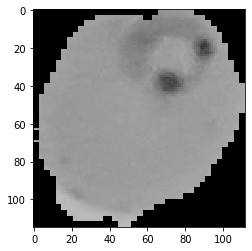

In [3]:
#### Just to see one image as a manner of example:
plotGrayImage(df["data"][0])

### Since I have notice that images have different dimmensions, I need to make them the same size.
But first I am goint be find the biggest one and make the rest the same size with zero values in the edges. 


In [4]:
maxSize = np.array([np.array(x).shape for x in df["data"]]).flatten().max()
maxSize

229

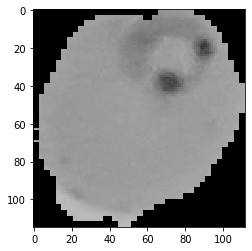

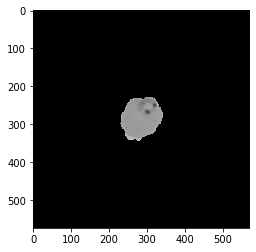

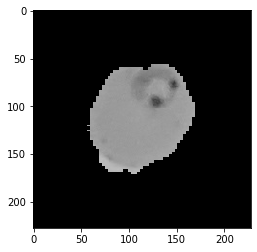

In [5]:
t = df["data"][0]
result = addBorderZeroPaddToImage(t, maxSize)
plotGrayImage(t)
plotGrayImage(result)
r = cropImage(result, maxSize)
plotGrayImage(r)

### Train-test-validation split

In [6]:
df_train_validation, df_test = train_test_split(df, test_size=0.1, random_state=0)

### Adjusting size of database images and make them a single vector

In [7]:
vectorImages = pd.DataFrame(df_train_validation["data"].apply(lambda x: resizeImage(x, maxSize).ravel()).values.tolist())
# Each column is a pixel of the original image
vectorImages.head(1)

,0,1,2,3,4,5,6,7,8,9,...,51974,51975,51976,51977,51978,51979,51980,51981,51982,51983
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-test-validation split

In [8]:
vectorImages_train, vectorImages_validation, labels_train, labels_validation = train_test_split(vectorImages, df_train_validation["status"], test_size=0.25, random_state=0)

In [9]:
model = LogisticRegression()
model.fit(vectorImages_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
model.score(vectorImages_validation, labels_validation)

0.5416666666666666

Since the accuracy is barely better than a flip a coin estimator, I have to change the strategy to improve the model. 

The current model does such a horrible job because the observable pattern (the one that has to be enclosed or segmented
by the classifier) is in different dimmensions in each sample so the the optimization algorithm does not where to go
in order to truly fit the model. 

In [11]:
def processToHistVectorImages(x, maxSize):
    vector = resizeImage(x, maxSize).ravel()
    return list(np.histogram(vector,bins=40)[0])[1:]

histVectorImages = pd.DataFrame(df_train_validation["data"].apply(lambda x: processToHistVectorImages(x, maxSize)).values.tolist())

In [12]:
histVectorImages_train, histVectorImages_validation, labels_train, labels_validation = train_test_split(histVectorImages, df_train_validation["status"], test_size=0.25, random_state=0)

In [13]:
histModel = LogisticRegression(max_iter=200)
histModel.fit(histVectorImages_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
histModel.score(histVectorImages_validation, labels_validation)

0.8690476190476191

#### Testing best model with untouched data:

In [15]:
test = pd.DataFrame(df_test["data"].apply(lambda x: processToHistVectorImages(x, maxSize)).values.tolist())

histModel.score(test,df_test["status"])

0.8933333333333333

In [16]:
# for index in range(len(df_test)):
#     predict = histModel.predict(np.array(df_test["histVectors"].iloc[index]).reshape(1,-1))
#     print("True value: " , df_test["status"].iloc[index])
#     print("  Predicted: ", predict)
#     plotGrayImage(df_test["data"].iloc[index])
#     print("-------------")